#Introduction:
Credit risk is the probability of a financial loss resulting from a borrower's failure to repay a loan. Essentially, credit risk refers to the risk that a lender may not receive the owed principal and interest, which results in an interruption of cash flows and increased costs for collection.


---


```Bank Credit Scoring``` will be used to  develop a model to predict debtor default, where default is defined as an overdue period exceeding 3 months.

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score, auc

In [146]:
df=pd.read_csv("/content/drive/MyDrive/Projects/Bank credit risk assessment/bank_credit_scoring_en.csv")



In [147]:
np.random.seed(28)

#Exploratory Data Analysis

In [148]:
df.shape

(18420, 18)

In [149]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18420 entries, 0 to 18419
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Debt                   18420 non-null  float64
 1   Delay, days            18420 non-null  int64  
 2   Primary limit          18420 non-null  float64
 3   BIRTHDATE              18420 non-null  object 
 4   SEX                    18420 non-null  object 
 5   EDU                    18420 non-null  object 
 6   INCOME                 18420 non-null  float64
 7   TERM                   18420 non-null  int64  
 8   Credit history rating  17488 non-null  object 
 9   LV_AREA                16297 non-null  object 
 10  LV_SETTLEMENTNAME      14661 non-null  object 
 11  INDUSTRYNAME           18420 non-null  object 
 12  PDN                    18420 non-null  float64
 13  CLIENTID               18420 non-null  int64  
 14  Scoring                16786 non-null  float64
 15  UN

In [150]:
numerical_features=["Debt","Primary limit","INCOME","PDN","CLIENTID","SCORINGMARK","UNDERAGECHILDRENCOUNT","VELCOMSCORING","FAMILYSTATUS"]

categorical_features =["BIRTHDATE","SEX","EDU","Credit history rating","LV_AREA","LV_SETTLEMENTNAME","INDUSTRYNAME"]

In [151]:
df.isnull().sum()

,0
Debt,0
"Delay, days",0
Primary limit,0
BIRTHDATE,0
SEX,0
EDU,0
INCOME,0
TERM,0
Credit history rating,932
LV_AREA,2123


In [152]:
values = np.prod(df.shape)
nans=df.isnull().sum().sum()

print(f'Percent of missed values is: {nans / values * 100:.2f}%')

Percent of missed values is: 5.42%


In [153]:
target=df["Delay, days"]
target.sort_values(ascending=False)

,"Delay, days"
3725,491
3930,491
3997,491
920,460
581,460
...,...
12,0
13,0
14,0
15,0


In [154]:
overdue=target[target>90].count()
print(f"No of overduers: {overdue}")
print(f"{overdue / df.shape[0] * 100:.2f}% percent of credits were delayed ")


No of overduers: 755
4.10% percent of credits were delayed 


In [155]:
df["Overdue"]=df["Delay, days"]>90

df["Overdue"].value_counts()

,count
Overdue,
False,17665
True,755


#Feature Engineering

In [156]:
label_encoders = {}
le = LabelEncoder()
le.fit([False, True])

df['Overdue'] = le.transform(df['Overdue'])
label_encoders['Overdue'] = le

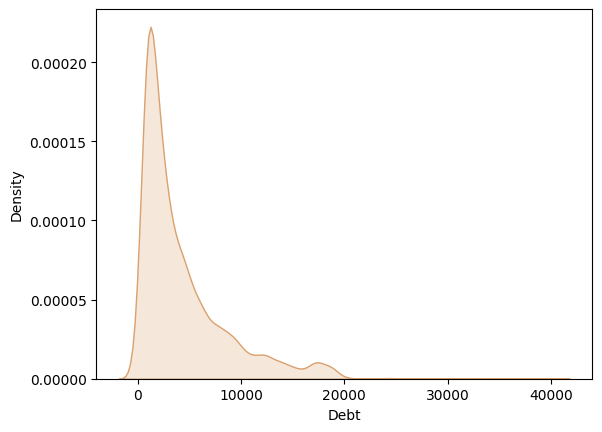

In [157]:
sns.kdeplot(data=df, x='Debt', color='#DAA06D', fill=True);

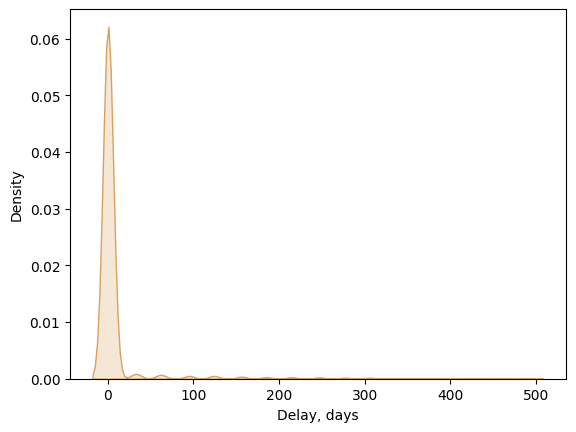

In [158]:
sns.kdeplot(data=df, x='Delay, days', color='#DAA05D', fill=True);

(90.0, 491.0)

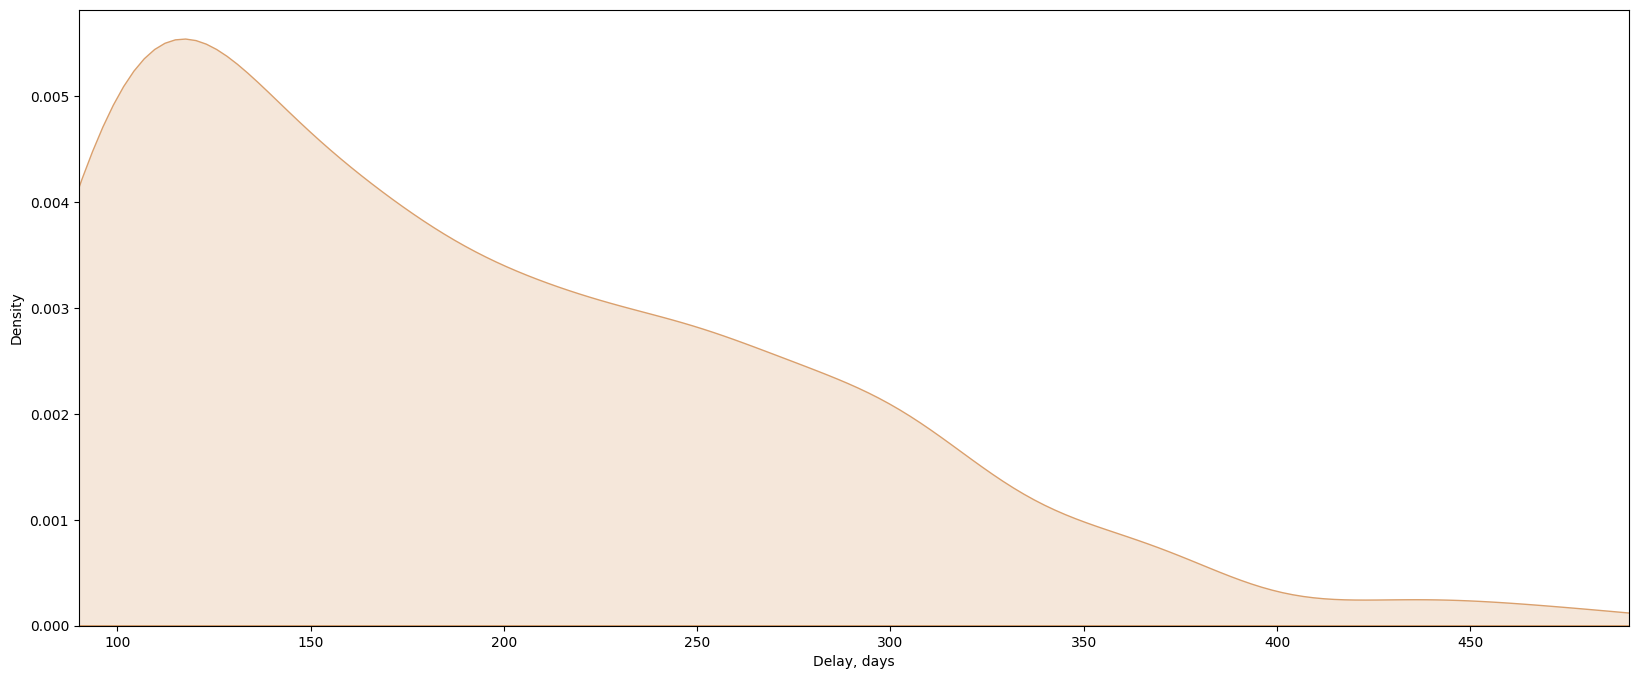

In [159]:
plt.figure(figsize=(20, 8))
sns.kdeplot(data=df.loc[df['Delay, days'] > 90], x='Delay, days', color='#DAA06D', fill=True);
plt.xlim((90, df['Delay, days'].max()))

In [160]:
df.drop(columns=["Delay, days"],axis=1,inplace=True)


In [161]:
df['BIRTHDATE'] = pd.to_datetime(df['BIRTHDATE'], errors='coerce')

# Now calculate age
df['BIRTHDATE'] = datetime.now().year - df['BIRTHDATE'].dt.year - 1

<Axes: xlabel='BIRTHDATE', ylabel='Density'>

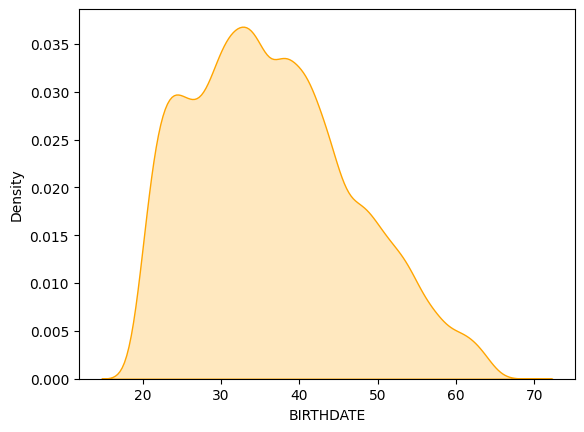

In [162]:
sns.kdeplot(data=df, x='BIRTHDATE', color='orange', fill=True)

In [163]:
df['SEX'].value_counts() / df.shape[0]


,count
SEX,
Male,0.610695
Female,0.389305


In [164]:
df['SEX'].loc[df['Overdue'] == 1].value_counts()

,count
SEX,
Male,436
Female,319


In [165]:


df.loc[df['EDU'] == 'Postgraduate', 'EDU'] = 'Higher Education'

edu = df['EDU'].value_counts()
edu

,count
EDU,
Vocational Secondary,9196
Higher Education,6150
Secondary Education,2519
Incomplete Higher Education,555


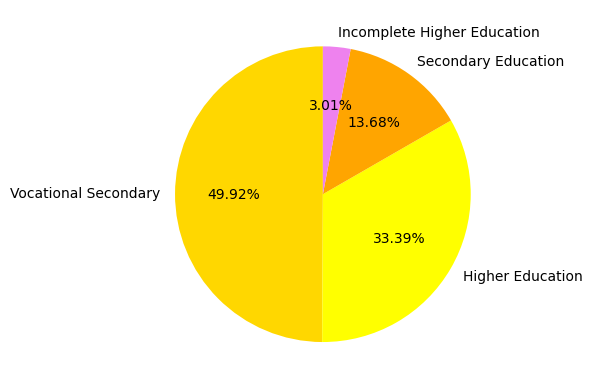

In [166]:
edu = df['EDU'].value_counts()
colors = ['gold', 'yellow', 'orange', 'violet', 'purple', 'red', 'brown']
plt.pie(x=edu, labels=edu.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(edu)]);

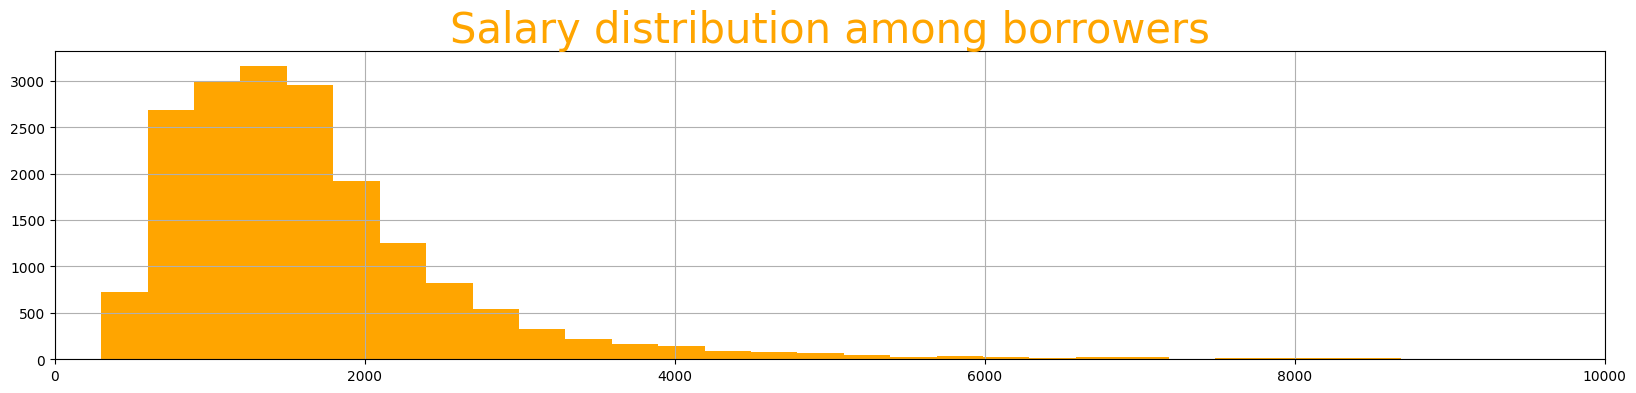

In [167]:
plt.figure(figsize=(20, 4))
df['INCOME'].hist(bins=100, color='orange')
plt.xlim((0, 10000))
plt.title(label='Salary distribution among borrowers', color='orange', fontsize=30);

In [168]:
df["Credit history rating"].value_counts().sort_values(ascending=False)

,count
Credit history rating,
B3,2154
C1,2080
C2,2012
C3,2006
B2,1701
D1,1387
B1,1335
D2,1060
A3,996


In [169]:
df["LV_AREA"].value_counts()

,count
LV_AREA,
Minsk City,4296
Minsk Region,3483
Vitebsk Region,1991
Gomel Region,1825
Brest Region,1770
Mogilev Region,1658
Grodno Region,1274


([<matplotlib.patches.Wedge at 0x7b8b68ef6ad0>,
 [Text(-0.8103461698358975, 0.7438676529008981, 'Minsk City'),
  Text(-0.7996526325694314, -0.755351353493709, 'Minsk Region'),
  Text(0.26291477647543565, -1.0681178868977301, 'Vitebsk Region'),
  Text(0.9116829666027074, -0.6154950596117622, 'Gomel Region'),
  Text(1.0945941684520522, 0.10892018357843757, 'Brest Region'),
  Text(0.797318944510901, 0.7578142917127012, 'Mogilev Region'),
  Text(0.2674419023308773, 1.0669933593409293, 'Grodno Region')],
 [Text(-0.4420070017286713, 0.4057459924913989, '26.36%'),
  Text(-0.4361741632196898, -0.41200982917838663, '21.37%'),
  Text(0.14340805989569216, -0.5826097564896708, '12.22%'),
  Text(0.4972816181469313, -0.3357245779700521, '11.20%'),
  Text(0.5970513646102102, 0.0594110092246023, '10.86%'),
  Text(0.4349012424604914, 0.41335325002510975, '10.17%'),
  Text(0.1458774012713876, 0.581996377822325, '7.82%')])

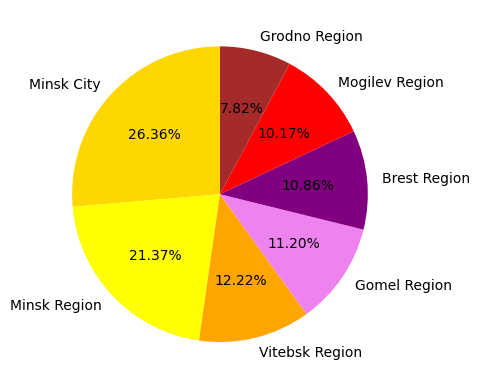

In [170]:
area = df['LV_AREA'].value_counts()
plt.pie(x=area, labels=area.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(area)])

In [171]:
df['LV_SETTLEMENTNAME'].value_counts()

,count
LV_SETTLEMENTNAME,
Minsk,5043
Mogilev,780
Gomel,751
Vitebsk,676
Brest,541
...,...
Ostroshitsy,1
Gurki,1
Borzdily,1


In [172]:
df['LV_SETTLEMENTNAME'] = df['LV_SETTLEMENTNAME'].str.capitalize()


In [173]:
top_10_cities = df['LV_SETTLEMENTNAME'].value_counts().index[:10]
filtered_data = df[df['LV_SETTLEMENTNAME'].isin(top_10_cities)]

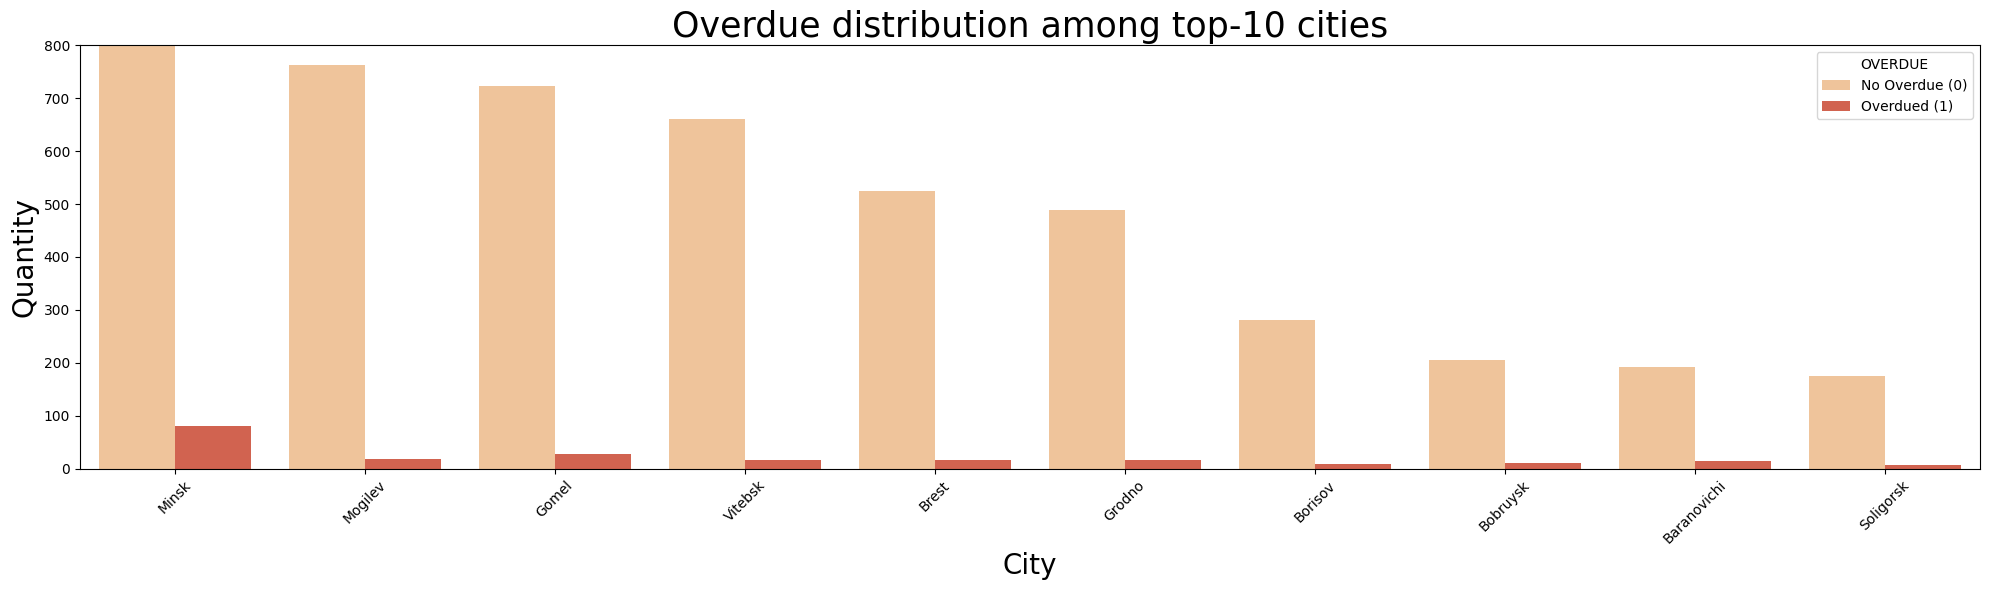

In [174]:
plt.figure(figsize=(20, 6))
sns.countplot(data=filtered_data, x='LV_SETTLEMENTNAME', hue='Overdue', palette='OrRd', order=top_10_cities)
plt.title('Overdue distribution among top-10 cities', fontsize=25)
plt.xlabel('City', fontsize=20)
plt.ylabel('Quantity', fontsize=20)
plt.ylim((0, 800))
plt.xticks(rotation=45)
plt.legend(title='OVERDUE', labels=['No Overdue (0)', 'Overdued (1)'])
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [175]:
df["INDUSTRYNAME"].value_counts()

,count
INDUSTRYNAME,
Manufacturing/Production,4323
Trade/Commerce,3100
Agro-Industrial Complex,1858
Public Services,1166
Construction,1154
Science and Education,1150
Transport/Transportation,1077
Ministry of Internal Affairs/Ministry of Emergency Situations/Ministry of Defense,1053
Medicine and Healthcare,981


In [176]:
# lets see how many clients took loan more than once
sum(df['CLIENTID'].value_counts() > 1)


2118

In [177]:
client_id_repeat = df['CLIENTID'].value_counts()
credit_repeat = client_id_repeat[client_id_repeat > 1].index
df['TOOK_ANOTHER_CREDIT'] = df['CLIENTID'].isin(credit_repeat).astype(int)
df['TOOK_ANOTHER_CREDIT'].value_counts()

,count
TOOK_ANOTHER_CREDIT,
0,12713
1,5707


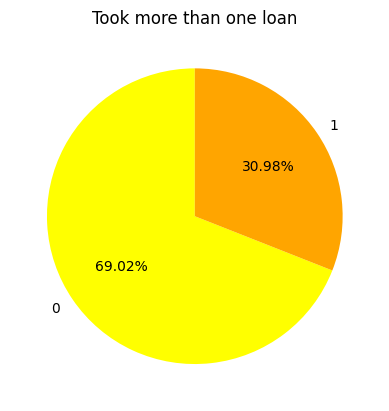

In [178]:
another = df['TOOK_ANOTHER_CREDIT'].value_counts()
plt.pie(x=another, labels=another.index, autopct='%1.2f%%', startangle=90, colors=colors[1 : len(another) + 1])
plt.title('Took more than one loan');

In [179]:
df.isnull().sum()


,0
Debt,0
Primary limit,0
BIRTHDATE,0
SEX,0
EDU,0
INCOME,0
TERM,0
Credit history rating,932
LV_AREA,2123
LV_SETTLEMENTNAME,3759


In [180]:
df.drop("VELCOMSCORING",inplace=True,axis=1)

In [181]:
missing_cols = ["Credit history rating", "LV_AREA", "LV_SETTLEMENTNAME", "Scoring"]
numeric_cols = df[missing_cols].select_dtypes(include=['number']).columns.tolist()
categorical_cols = df[missing_cols].select_dtypes(include=['object', 'category']).columns.tolist()
df_impute = df[numeric_cols + categorical_cols].copy()
encoders = {}


In [182]:
for col in categorical_cols:
    df_impute[col] = df_impute[col].astype('category')
    encoders[col] = dict(enumerate(df_impute[col].cat.categories))
    df_impute[col] = df_impute[col].cat.codes.replace(-1, np.nan)

In [183]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_impute), columns=df_impute.columns)
for col in categorical_cols:
    df_imputed[col] = df_imputed[col].round().astype(int)
    df_imputed[col] = df_imputed[col].map(encoders[col])

df[numeric_cols + categorical_cols] = df_imputed[numeric_cols + categorical_cols]

In [187]:
df.isnull().sum().sum()

np.int64(0)

In [188]:
for col in categorical_features:
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()

,Debt,Primary limit,BIRTHDATE,SEX,EDU,INCOME,TERM,Credit history rating,LV_AREA,LV_SETTLEMENTNAME,INDUSTRYNAME,PDN,CLIENTID,Scoring,UNDERAGECHILDRENCOUNT,FAMILYSTATUS,Overdue,TOOK_ANOTHER_CREDIT
0,6063.50,7000.0,22,1,3,703.07,60,1,1,136,0,0.98,919517,233.0,0,1,0,0
1,3765.04,5000.0,18,0,0,1693.68,60,5,3,197,3,0.17,539353,221.6,1,1,0,1
2,2067.66,2650.0,39,0,2,724.49,60,8,2,371,6,0.40,818913,161.4,0,2,0,0
3,2370.39,3000.0,33,0,3,1045.84,60,3,4,77,10,0.29,691598,216.0,0,2,0,0
4,2280.55,3000.0,8,0,0,1092.65,60,6,4,197,6,0.63,425193,199.0,0,2,0,0


In [189]:
label_encoders

{'Overdue': LabelEncoder(),
 'BIRTHDATE': LabelEncoder(),
 'SEX': LabelEncoder(),
 'EDU': LabelEncoder(),
 'Credit history rating': LabelEncoder(),
 'LV_AREA': LabelEncoder(),
 'LV_SETTLEMENTNAME': LabelEncoder(),
 'INDUSTRYNAME': LabelEncoder()}

In [195]:
df.to_csv('/content/drive/MyDrive/Projects/Bank credit risk assessment/processed_bank_credit_scoring_en.csv', index=False)

In [192]:
X = df.drop('Overdue', axis=1)
y = df['Overdue']

<Axes: >

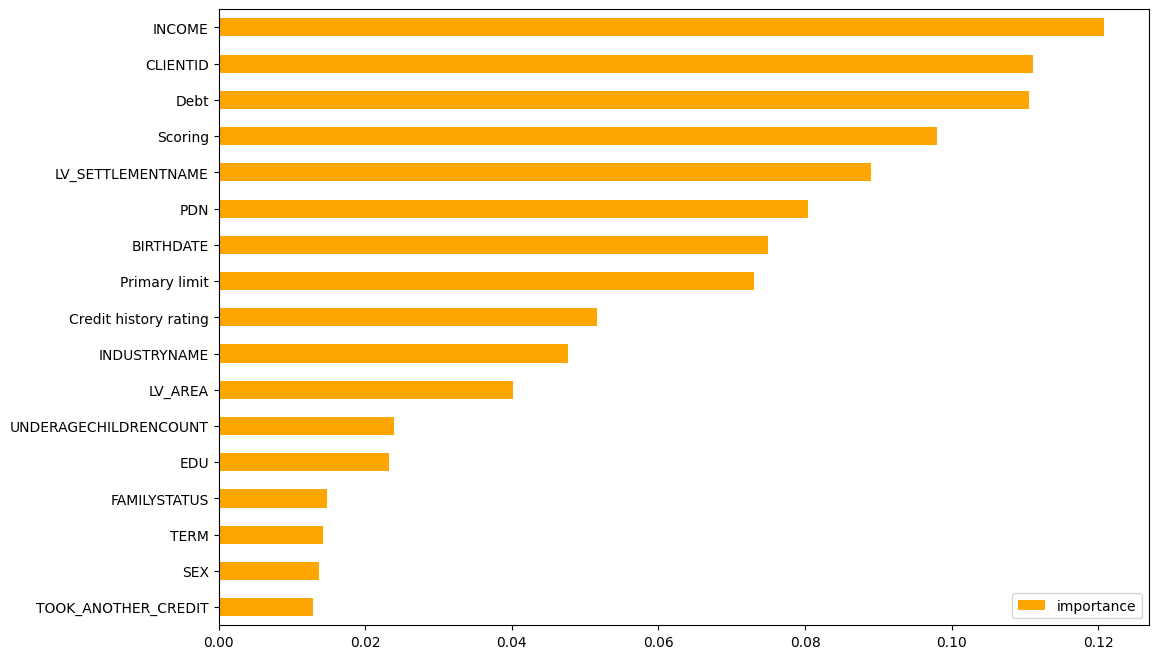

In [193]:
best_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=28,
)

best_rf.fit(X, y)
importance = best_rf.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='orange')

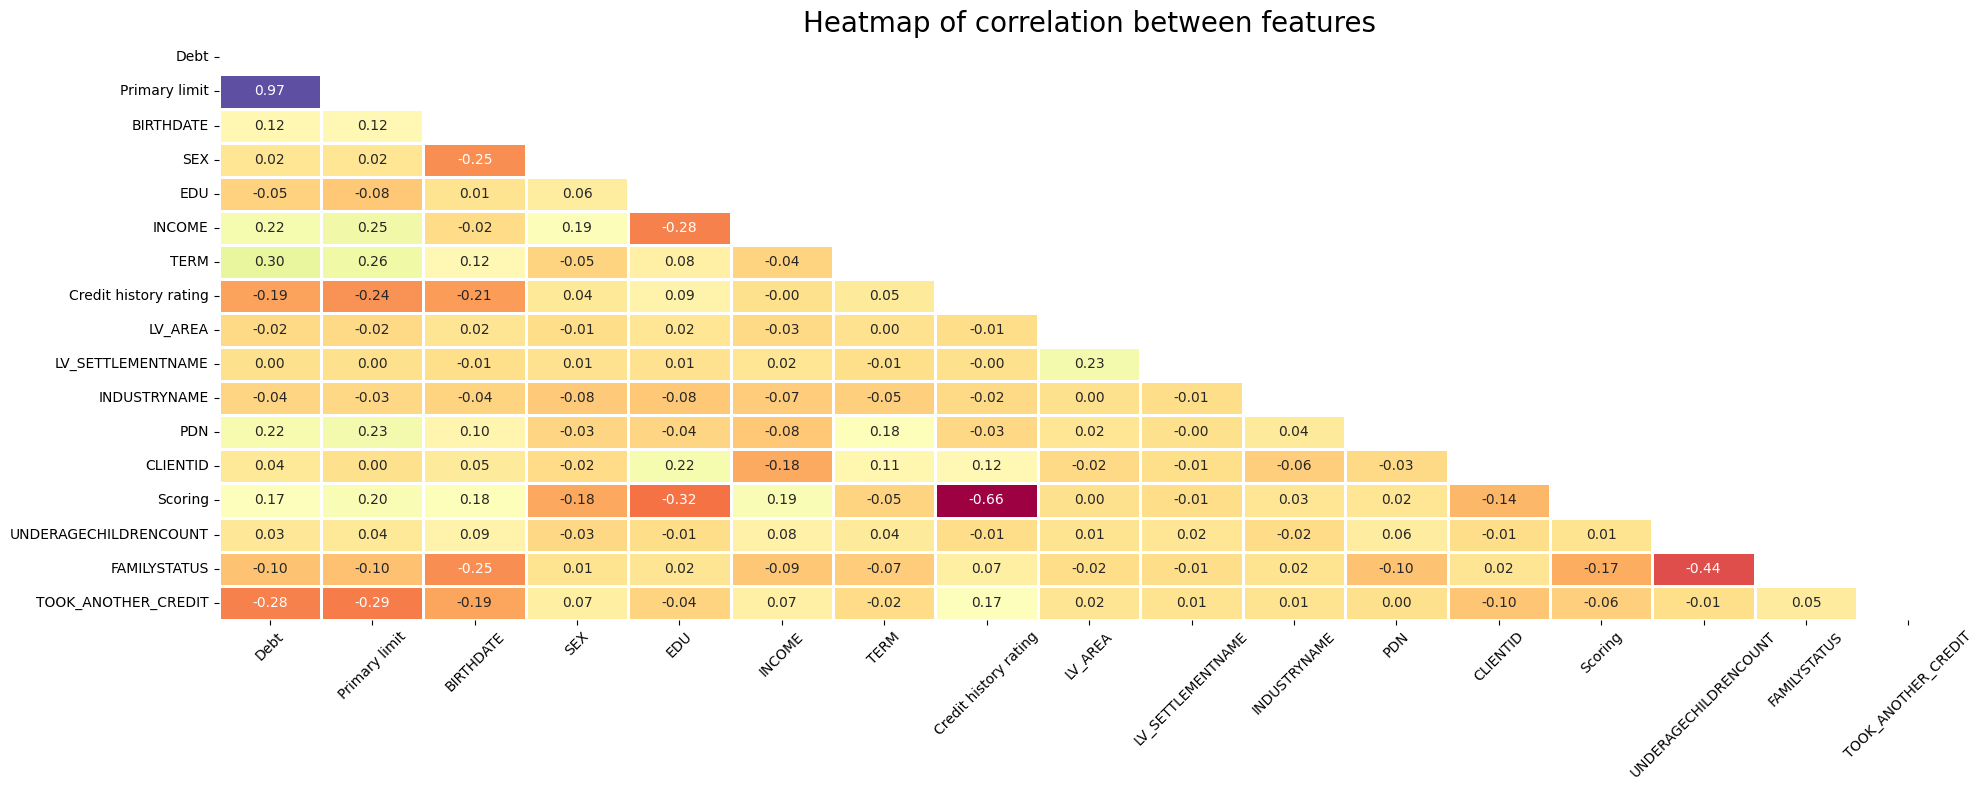

In [194]:
plt.figure(figsize=(20, 8))
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.title('Heatmap of correlation between features', fontsize=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [198]:
x = add_constant(df.drop('Overdue', axis=1))
vif = pd.DataFrame()
vif['Feature'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
print(vif)

                  Feature         VIF
0                   const  143.235674
1                    Debt   17.511014
2           Primary limit   17.918825
3               BIRTHDATE    1.235410
4                     SEX    1.209115
5                     EDU    1.260139
6                  INCOME    1.383918
7                    TERM    1.191170
8   Credit history rating    2.105518
9                 LV_AREA    1.059632
10      LV_SETTLEMENTNAME    1.057384
11           INDUSTRYNAME    1.030225
12                    PDN    1.132338
13               CLIENTID    1.123969
14                Scoring    2.299078
15  UNDERAGECHILDRENCOUNT    1.259201
16           FAMILYSTATUS    1.373522
17    TOOK_ANOTHER_CREDIT    1.194678


Primary limit and debt are higly correlated. They have confused the model you can see in purple block. One of them needs to get get removed so Primary limit should be dropped as it is less important which is verified in feature importance plot.

In [199]:
X.drop(columns=["Primary limit"],axis=1,inplace=True)

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [201]:
columns = ['Debt', 'BIRTHDATE', 'SEX', 'EDU', 'INCOME', 'TERM',
       'Credit history rating', 'LV_AREA', 'LV_SETTLEMENTNAME',
       'INDUSTRYNAME', 'PDN', 'CLIENTID', 'SCORINGMARK',
       'UNDERAGECHILDRENCOUNT', 'FAMILYSTATUS',
       'TOOK_ANOTHER_CREDIT']

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [203]:
log_reg = LogisticRegression(class_weight='balanced', random_state=28, max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

In [207]:
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6564


In [204]:
coefficients = log_reg.coef_
intercept = log_reg.intercept_

coeff_df = pd.DataFrame(coefficients.T, columns=['Coefficient'], index=columns)
print(f'Intercept: {intercept[0]}')
coeff_df

Intercept: -0.5392127247916415


,Coefficient
Debt,0.169948
BIRTHDATE,0.015464
SEX,0.022683
EDU,0.204270
INCOME,-0.875754
TERM,0.065863
Credit history rating,0.025309
LV_AREA,-0.042629
LV_SETTLEMENTNAME,0.046551
INDUSTRYNAME,-0.264887


In [205]:
classification_report_output = classification_report(y_test, y_pred, zero_division=0)
print(classification_report_output)

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      3533
           1       0.08      0.75      0.15       151

    accuracy                           0.66      3684
   macro avg       0.53      0.70      0.47      3684
weighted avg       0.95      0.66      0.76      3684



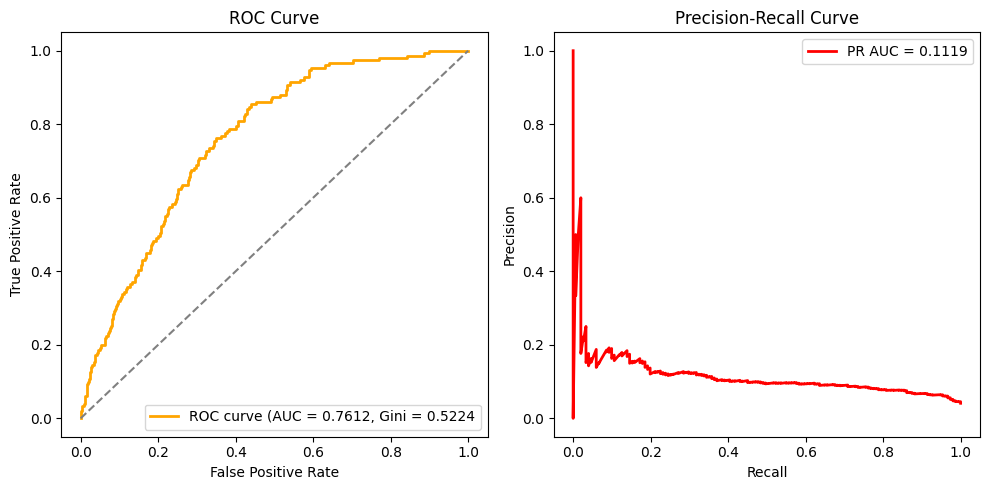

In [206]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

gini = 2 * roc_auc - 1

# Plotting ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f}, Gini = {gini:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Plotting PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='red', lw=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()